In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import pearsonr, poisson, multivariate_normal, norm, vonmises, multivariate_t, rice
from scipy.special import laguerre, i0, i1
# from dw_tools      import multivariatet as mvt

In [3]:
plt.rcParams.update({'font.size': 12})

# Global Scaling for Difference Maps

## Introduction

Structure factor amplitudes from an unperturbed ("OFF") crystal and from a perturbed ("ON") crystal are not on the same scale (see **Background**). In **Scaling difference maps**, we ask: what is the best way to scale both the ON and the OFF structure factor amplitudes (SFAs), such that the resulting difference map is:

- as unbiased as possible (because we don't want a wrong difference map), and
- the on-off correlation is as low as possible (because, even though it is a real effect, we don't want ground state depletion to dominate the difference map)?

These computations are supported by a formalism provided in the **Background** section.

Using this formalism, we find that it's justifiable to scale the ON map to the OFF map. Additionally, we show in the **Expected MSE** section that we can quantify the bias. In the section on **The role of measurement error**, when we consider both measurement error and MSE together, we propose that the MSE can be added to the weight term for weighting difference maps. 

# Background

### The "random-diffuse" model
In the **random-diffuse Coppens model**, we consider a crystal on which diffraction data were collected in both an "OFF" ground state (GS) and an "ON" excited state (ES), in which a fraction $p$ of molecules, randomly distributed throughout the crystal, are excited. In this model, the ON structure factors depend on $E^{off}=E^{gs}$, and the excited-state structure factors $E^{es}$,

$$E^{on} = p E^{es} + (1-p) E^{gs} \qquad \qquad \qquad [1]$$

### ON structure factors are on average smaller
In general, we can expect an excited state electron density map to be blurrier than a ground state electron density map. This can happen for two reasons:
1. The excited state is likely to be less of a pure state than the ground state, because of heating, because there are plausibly more excited states than ground states, and because there may still be molecules left in the ground state. We'll refer to this as **"thermal blur"**. A practical consequence is that excited state structure factor amplitudes (SFAs) are expected to truly be smaller than GS SFAs.
2. We typically do not know much about the phase difference between GS and ES structure factors, except that its expectation value is usually 0. As a consequence, the amplitude of the expected value of the complex $F^{es}$ is typically smaller than the amplitude of $F^{gs}$. This is a kind of **"inference blur"**. 

An analogy with image blurring makes clear why these blurring effects are problematic. First, "inference blur" means that even if there is no systematic changes in e.g. rotamer states, the difference map will be dominated by features suggesting the depletion of the ground state (for comparison, take a blurred version of an image and subtract the original image). Now, if the "ON" image truly is blurrier, as for thermal blur, this effect reflects reality. However, this is still not very interesting, as local changes are typically more important. 

It is indeed common practice to scale ON data to OFF data, e.g. using SCALEIT. Is this a sensible thing to do? A benefit of the multivariate Wilson distribution is that we can generate simulated perturbation data with known ground truth, and address this question precisely.

### Recap of the multivariate Wilson distribution
Let's consider two correlated data sets (e.g. for 'ON' and 'OFF' time-resolved data). We will use $F$ for structure factors in general, and assume them to be complex numbers with amplitudes $|F|$. We will use $E$ for normalized structure factors, whose squared amplitudes have an expectation value $\left<E\ E^*\right>=\left<|E|^2\right>=1$. Unless stated otherwise, we will only consider acentric reflections.

Consider a pair of structure factors $\left(F_1, F_{3}\right)$, with $F_1=(F_{1x}, F_{1y})$, and $F_{3}=(F_{3x}, F_{3y})$. Subscripts $x$ and $y$ denote the real and imaginary components of these complex structure factors. Under the multivariate Wilson model, their distribution is jointly normal, $\sim \mathcal{N}\left((0,0,0,0),C\right)$, with 

$$
C = 
\frac{\Sigma}{2}
\begin{bmatrix}
1 & 0 & r & 0 \\
0 & 1 & 0 & r \\
r & 0 & 1 & 0 \\
0 & r & 0 & 1  
\end{bmatrix} \qquad \qquad \qquad    [1]
$$ 

As a consequence, $\left<|E_1|^2\right>=\left<E_{1x}^2+E_{1y}^2\right>=\Sigma$. For normalized structure factors, $\Sigma=1$. For the case of a ground state and excited state, it is probably productive to assume that true ground state and excited state structure factors live on the same scale for the purposes of thinking about difference maps, so $\Sigma_1=\Sigma_3=\Sigma$. Otherwise, we'd have to use a scale $\Sigma_1$ for $F_1$ and a scale $\Sigma_3$ for $F_3$ and use a 'mixed scale' $\sqrt{\Sigma_1\Sigma_3}$ for the mixed off-diagonal elements of $C$.

A word on notation: ```r``` refers to $r$ above: a correlation coefficient between real or between imaginary components of two structure factors. We have been referring to this as the "double-Wilson parameter".

### Conditioning on a known structure factor amplitude
Now, let's examine what happens when we know one of the structure factors, e.g. $E_3$ (note that we can set one of the phases, e.g., $\phi_3$, to 0 or any other number without loss of generality). When we have a known value for $E_3=(E_{3,x}, E_{3,y})$, the conditional distribution of $E$ becomes a bivariate normal with mean $\mu_{1|3} = r E_{3}$ and covariance matrix 

$$C_{1|3} = \frac{\Sigma}{2}
\begin{bmatrix}
1-r^2 & 0 \\
0 & 1-r^2
\end{bmatrix} \qquad \qquad \qquad [2]
$$

As in **notebook 6**, it is helpful to write this in polar coordinates using $E_1 = R_1 \left(\cos(\phi_1),\sin(\phi_1)\right)$ and $\mu = r E_3 = R_3 \left(\cos(\phi_3),\sin(\phi_3)\right)$, such that

$$
\begin{align}
P\left(R_1,\phi_1 | R_3, \phi_3\right) = 
                                        \frac{R_1}{\pi \Sigma (1-r^2)}  
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 \cos(\phi_1-\phi_3)}{\Sigma(1-r^2)}          
                                           \right)
\end{align}                           \qquad \qquad [3]                
$$

Note that the definition of $R_3$ above has $r$ absorbed in it.

We can marginalize over $\Delta\phi = \phi_1-\phi_3$,

$$
\begin{align}
P\left(R_1 | R_3\right) & = \int_{0}^{2\pi} d\Delta\phi
                                 P\left(R_1, \Delta\phi | R_3, \phi_3=0\right) \\
                        & = \frac{2 R_1}{\Sigma (1-r^2)} 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                 \right)
                            I_0\left(
                                \frac{2 R_1 R_3}{\Sigma(1-r^2)}          
                            \right)
\end{align}            \qquad \qquad [4]                               
$$

which is the **Rice distribution**. 

## Criteria for $|E^{on}|-|E^{off}|$ difference maps:
Starting from true normalized structure factor amplitudes for the ground state (GS; $gs$) and excited state (ES; $es$), we see that, on average, $|E^{on}| < |E^{off}|$, under this model. This is since in the complex sum $E^{on} = p E^{es} + (1-p) E^{gs}$, typically $E^{gs}$ and $E^{es}$, are not parallel in the complex plane. It is, therefore, a slight abuse of notation to refer to the ON amplitudes as normalized if we start from the assumption that $E^{es}$ and $E^{gs}$ are normalized.

In the next sections, we look at how to balance two objectives:
- minimize map MSE error relative to the true difference map
- minimize absolute correlation with the OFF map

For now, we will neglect measurement error for simplicity. We will consider the case _with_ measurement error in the section **The role of measurement error**.

Does it make sense to minimize absolute correlation with the ground state? We observe that under the double-Wilson model, the expected value of $E^{on}=pE^{es}+(1-p)E^{gs}$, 

$$\mathbb{E}(E^{on} \big| E^{off})=\left(1-p+pr\right)E^{off} = \left(1-p(1-r)\right)E^{off} = \left(1-\theta\right)E^{off}$$

where we identified $E^{off}=E^{gs}$ and $\mathbb{E}(E^{es})=r E^{gs}$ and defined $\theta=p(1-r)$. In addition, 

$$
\mathrm{Var}\left(E^{on} \big| E^{off}\right)=\frac{1}{2} p^2 (1-r^2) \Sigma I 
$$

The conditional expected amplitude, $\mathbb{E}(|E^{on}|)$, is given by the mean of the corresponding Rice distribution (yielding an expression which is numerically close to $(1-\theta) |E^{off}|$. This expected amplitude is smaller than $|E^{off}|$ (except when $p=0$ or $p=1$ or $r_{DW}=1$). This, again, is a real effect, in principle observable in diffraction patterns. Crystal heating is a special case of the same effect. In difference maps, this effect shows up as negative covariance with the ground state. This is also true: the ground state is depleted in time-resolved X-ray experiments.

### MSE map error and Covariance with another map
Let's examine the case of two sets of structure factors, $F=(A,B)$ and $F'=(A',B')$ such that

$$\rho(x) = \sum_h A_h \cos(2\pi hx) + B_h \sin(2 \pi hx)$$ and likewise for $\rho'(x)$ are the corresponding maps. We will examine the 1D case and ignore crystallographic symmetry. The change from 1D to 3D is likely trivial. Then,

$$\Delta \rho(x) = \rho'(x) - \rho(x) = \sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)$$ 
with $\Delta A = A'-A$ etc. is their difference map.

The variance of this difference map is given by: 

$$
\begin{align}
    Var(\Delta \rho) & = \int_0^L dx (\Delta \rho(x))^2 \\
    & = \int^L_0 dx \left(\sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)\right)^2 \\
    & = \frac{L}{2}\sum_h \left((\Delta A_h)^2 + (\Delta B_h^2)\right)
\end{align}
$$ 

where we take into account the mean value of $\cos^2$ or $\sin^2$ for sines and cosines that fit in the box an integer number of times ($1/2$), and that all other cross terms average to 0.

The covariance between two maps (e.g., $\rho(x)$ and $\Delta \rho(x)$) goes as 

$$
\begin{align}
    Cov(\rho,\Delta \rho) & =\int dx \rho(x) \Delta \rho(x) \\
                          & = \int dx \left(\sum_h \Delta A_h \cos(2\pi hx) + \Delta B_h \sin(2 \pi hx)\right)\left(\sum_h A_h \cos(2\pi hx) + B_h \sin(2 \pi hx)\right) \\
                          & = \frac{L}{2}\sum_h (A\Delta A_h + B\Delta B_h)
\end{align}                          
$$ 
by the same arguments.

# Scaling difference maps
Applying this formalism to synthetic data obtained by simulation of the multivariate Wilson model, we want to find scale coefficients $k$, $k'$ such that

- we minimize MSE between the approximate map $(k |F^{on}| - k'|F^{off}|)\exp(i\phi^{off})$, and the true map $F^{es} - F^{gs}$


- we minimize (absolute) covariance of $(k |F^{on}| - k'|F^{off}|)\exp(i\phi^{off})$ with $F^{off}$

In [4]:
def calc_MSE(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, p, scale_by_p=True):
    '''
    As described above, this function calculates the expected mean square error (MSE) between a naive estimator 
    of the difference map and the true difference map. Measurement errors are not considered.
    '''
    if scale_by_p:
        pscale = p
    else:
        pscale = 1
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)

    # now MSE = Var(\delta\rho) = sum(delta_A**2 + delta_B**2) = sum(abs(delta_F)**2)
    MSE = np.mean(np.abs(deltaF_off_phased - pscale*(E_es-E_gs))**2)
    return MSE

def calc_Cov_off(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs):
    '''
    This function calculates the expected covariance between estimates of the difference map 
    and the OFF map. Measurement errors are not considered.
    '''
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_gs)\
                     )
    return Cov_off

def calc_Corr_true(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs):
    '''
    This function calculates the expected correlation between estimates of the difference map 
    and the true difference map. Measurement errors are not considered.
    '''
    deltaF_off_phased = (k[0]*E_on_abs - k[1]*E_off_abs)*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_es-E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_es-E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_es-E_gs)**2)
    return Cov_off/(np.sqrt(norm1*norm2))

def calc_mean_DoM(k, E_on_abs, E_off_abs):
    '''
    This function calculates the average differences in the magnitudes of the scaled 
    structure factor amplitudes.
    '''
    DoM = (k[0]*E_on_abs - k[1]*E_off_abs)
    return np.mean(DoM)

## Initial optimization for $k$ and $k'$

We start by generating some synthetic data from the double-Wilson model. 

We can either 

1. sample $E^{es}$ conditional on a value of $E^{gs}$, or
2. sample $E^{es}$ and $E^{gs}$ from their joint distribution.

Our conclusions do not depend on this choice.

#### Sampling conditional on $E^{gs}$

In [5]:
rng  = default_rng()
r    = 0.95       #double-Wilson parameter
p    = 0.4        # excited state fraction
E_gs = 1.8 + 1j*0   # assumed GS structure factor (typically in the range from 0 to 3)
Nref = 10000

# conditional mean and cov for the ES structure factor
mean = r * np.asarray([np.real(E_gs),np.imag(E_gs)])
cov  = 0.5*np.asarray([[ 1-r**2,       0],\
                      [0,       1 -r**2]])
vals = rng.multivariate_normal(mean, cov, Nref)

E_es      = vals[:,0] + 1j * vals[:,1]
E_off     = E_gs
E_on      = (1-p)*E_gs + p*E_es
phi_off   = np.angle(E_off)
phi_on    = np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

#### Unconditional sampling of $E^{gs}$ and $E^{es}$

In [6]:
rng  = default_rng()
r    = 0.95       # double-Wilson parameter
p    = 0.4        # excited state fraction
Nref = 10000

mean = [0,0,0,0]                
cov  = 0.5*np.asarray([[1, 0, r, 0 ],\
                       [0, 1, 0, r ],\
                       [r, 0, 1, 0 ],\
                       [0, r, 0, 1 ]])

vals = rng.multivariate_normal(mean, cov, Nref)

E_gs      = vals[:,0] + 1j * vals[:,1]
E_es      = vals[:,2] + 1j * vals[:,3]
E_off     = E_gs
E_on      = (1-p)*E_gs + p*E_es
phi_off   = np.angle(E_off)
phi_on    = np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

In [7]:
nmax = 100
MSE_obs     = np.zeros((nmax,nmax))
cov_off_obs = np.zeros((nmax,nmax))
corr_true   = np.zeros((nmax,nmax))
mean_DoM    = np.zeros((nmax,nmax))
k_range = np.linspace(0.8,1.2,nmax)/p
for k1 in tqdm(range(0,nmax)):
    for k2 in range(0,nmax):
        k = [k_range[k1],k_range[k2]]
        MSE_obs[    k1,k2] = calc_MSE(      k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, p, scale_by_p=False)
        cov_off_obs[k1,k2] = calc_Cov_off(  k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
        corr_true[k1,k2]   = calc_Corr_true(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
        mean_DoM[   k1,k2] = calc_mean_DoM( k, E_on_abs, E_off_abs)

100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_1932574/3449568034.py:38: SyntaxWarning: invalid escape sequence '\ '
  axs[2].set_title("Corr w\ true diff map (same)")


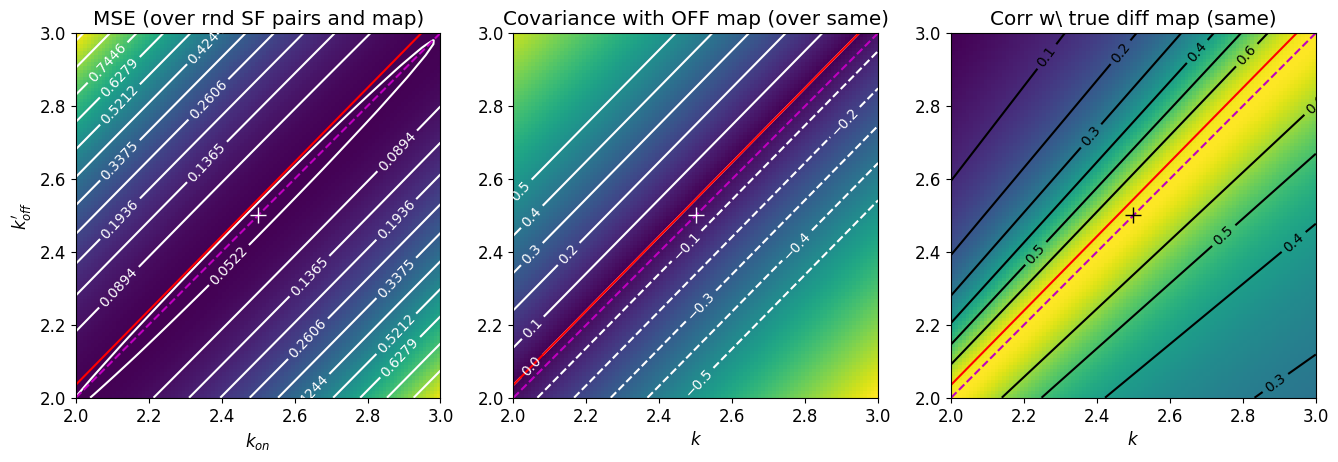

In [8]:
fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
extent = [k_range[0], k_range[-1], k_range[0], k_range[-1]]
axs = _axs.flatten()

min_MSE=np.amin(MSE_obs.flatten())
max_MSE=np.amax(MSE_obs.flatten())

axs[0].imshow(MSE_obs, origin='lower', extent=extent)
cs = axs[0].contour(MSE_obs,\
                    levels=np.linspace(1.02*np.sqrt(min_MSE),\
                                       0.98*np.sqrt(max_MSE),12)**2,\
                    colors='w', extent=extent)
axs[0].clabel(cs, inline=True, fontsize=10)
axs[0].plot(k_range[[0,-1]],k_range[[0,-1]],'m--')
axs[0].plot(1/p,1/p,'w+',markersize=12)
axs[0].set_title("MSE (over rnd SF pairs and map)")
axs[0].set_xlabel(r"$k_{on}$") # validated
axs[0].set_ylabel(r"$k_{off}'$")

axs[1].imshow( np.abs(cov_off_obs), origin='lower', extent=extent)
cs=axs[1].contour(cov_off_obs,levels=np.linspace(-0.5,0.5,11),colors='w', extent=extent)
axs[1].clabel(cs, inline=True, fontsize=10)
axs[1].plot(k_range[[0,-1]],k_range[[0,-1]],'m--')
axs[0].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[1].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[1].plot(1/p,1/p,'w+',markersize=12)
axs[1].set_title("Covariance with OFF map (over same)")
axs[1].set_xlabel(r"$k$")
axs[1].set_xlim(k_range[[0,-1]])
axs[1].set_ylim(k_range[[0,-1]])

axs[2].imshow( corr_true, origin='lower', extent=extent)
cs=axs[2].contour(corr_true,levels=np.linspace(-1,1,21),colors='k', extent=extent)
axs[2].plot(k_range[[0,-1]],k_range[[0,-1]],'m--')
axs[2].clabel(cs, inline=True, fontsize=10)
axs[2].contour(cov_off_obs,levels=[0],colors='r', extent=extent)
axs[2].plot(1/p,1/p,'k+',markersize=12)
axs[2].set_title("Corr w\ true diff map (same)")
axs[2].set_xlabel(r"$k$")
plt.show()

### Interpretation
- The red line is the line of 0 covariance of the inferred difference map with the $ground\ state$ electron density map. In good approximation, it goes through the origin. That is, we only care about the $k/k'$ ratio, reducing the estimation of $k$ and $k'$ to a 1D optimization.
- The magenta dashed line represents $k = k'$. At the white plus sign  in center of each image (black in the third panel), $k=k'=1/p$ yields (close to) minimal MSE relative to the true difference map. 
- The line with 0 covariance with the OFF map goes nearly through the point of minimum MSE: one can eliminate correlation with the OFF map without much loss of accuracy.
- Note, however, that the correlation coefficient with the true difference map falls off asymmetrically with distance from good $k/k'$ ratios: better subtract too little OFF than too much OFF state. This is because the true difference map has some negative correlation with the true difference map.

## 1D optimization
To simplify our approach based on the above considerations, we set $k'=1$ and multiply the true difference map by $p$. That is, we optimize the approximate difference map $(k |F^{on}| - |F^{off}|)\exp(i\phi^{off})$, relative to the map $p(F^{es} - F^{off})$. This speeds things up a lot.

To reduce scrolling, we repeat the sample generation code here:

In [9]:
rng  = default_rng()
r    = 0.95       # double-Wilson parameter
p    = 0.4        # excited state fraction
Nref = 100000

mean = [0,0,0,0]                
cov  = 0.5*np.asarray([[1, 0, r, 0 ],\
                       [0, 1, 0, r ],\
                       [r, 0, 1, 0 ],\
                       [0, r, 0, 1 ]])

vals = rng.multivariate_normal(mean, cov, Nref)

E_gs      = vals[:,0] + 1j * vals[:,1]
E_es      = vals[:,2] + 1j * vals[:,3]
E_off     = E_gs
E_on      = (1-p)*E_gs + p*E_es
phi_off   = np.angle(E_off)
phi_on    = np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

In [10]:
nmax = 200
MSE_obs     = np.zeros((nmax,1))
cov_off_obs = np.zeros((nmax,1))
mean_DoM    = np.zeros((nmax,1))
k_range = np.linspace(0.8,1.2,nmax)
for k1 in tqdm(range(0,nmax)):
    k = [k_range[k1],1]
    MSE_obs[k1]     = calc_MSE(    k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, p)
    cov_off_obs[k1] = calc_Cov_off(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs)
    mean_DoM[k1]    = calc_mean_DoM(k, E_on_abs, E_off_abs)

100%|██████████| 200/200 [00:01<00:00, 105.83it/s]


## Proposed correction factor

A simple way to adjust scales is by using the average ratio of amplitudes, the median ratio of amplitudes, or the ratio of the sums of amplitudes.

In [11]:
k1=np.mean(np.abs(E_off)/np.abs(E_on))
k2=np.median(np.abs(E_off)/np.abs(E_on))
k3=np.sum(np.abs(E_off))/np.sum(np.abs(E_on))
print(k1)
print(k2)
print(k3)

1.03801780897216
1.0122245027006664
1.0120030471947823


Alternatively, we can calculate the expected values of OFF and ON structure factors amplitudes given their correlation and the excited state fraction under the double-Wilson model. The ratio of these expected amplitudes provides a good proposal for how we can rescale the observed ON structure factor amplitudes.

As a technical detailth``e spi.y sa``ts mean of the Rice distribution is numerically not very well behaved. Hence we introduce some calculations ourselves.

In [12]:
def lag_pol(x): #Laguerre polynomial
    result = np.exp(x/2)*((1-x)*i0(-x/2)-x*i1(-x/2))
    return result
def rice_mean(nu,sigma):
    '''The scipy stats version sometimes produces NaNs unnecessarily'''
    result = sigma*np.sqrt(np.pi/2)*lag_pol(-nu**2/(2*sigma**2))
    return result

In [13]:
cond_mean   = np.abs(E_gs) * (1-p*(1-r))
nu          = cond_mean            
cond_var_ac = 0.5*p**2*(1-r**2)
sigma_ac    = np.sqrt(cond_var_ac) 
b           = nu/sigma_ac
scale       = sigma_ac

k4 = np.abs(E_gs)/rice.mean(b=b, scale=scale)
for n in range(k4.size):
    if np.isnan(k4[n]):
        k4[n] = np.abs(E_gs)/rice_mean(nu,sigma_ac)
        print("used option 2!")
    if np.isnan(k4[n]):
        k4[n] = np.abs(E_gs)/(1.125*np.sqrt(np.pi/4)*nu)
        print("used option 3!")
print(np.median(k4))
# print(f"Proposed scale factor, k: {k_expected:.4f}")

1.0144266619341962


Generally, the median ratio or the ratio of sums is more robust and yields better solutions below:

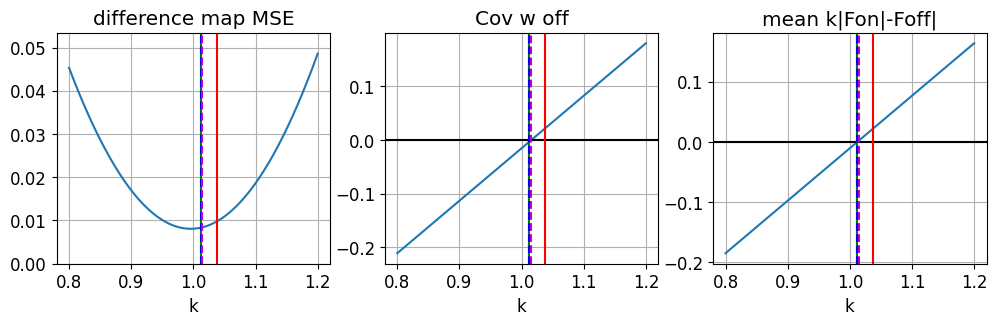

In [14]:
k4=np.median(k4)

plt.figure(figsize=(12,3))
ax=plt.subplot(1,3,1)
ax.plot(k_range,MSE_obs)
plt.axvline(x=k1,color='r',linestyle='-')
plt.axvline(x=k2,color='g',linestyle='-')
plt.axvline(x=k3,color='b',linestyle='--')
plt.axvline(x=k4,color='m',linestyle='--')
ax.set_ylim([0, 1.1*np.amax(MSE_obs)])
ax.set_xlabel('k')
ax.set_title('difference map MSE')
plt.grid()

ax=plt.subplot(1,3,2)
plt.plot(k_range,cov_off_obs)
plt.axhline(color='k')
plt.axvline(x=k1,color='r',linestyle='-')
plt.axvline(x=k2,color='g',linestyle='-')
plt.axvline(x=k3,color='b',linestyle='--')
plt.axvline(x=k4,color='m',linestyle='--')
ax.set_xlabel('k')
ax.set_title('Cov w off')
plt.grid()

ax=plt.subplot(1,3,3)
plt.plot(k_range,mean_DoM)
plt.axhline(color='k')
plt.axvline(x=k1,color='r',linestyle='-')
plt.axvline(x=k2,color='g',linestyle='-')
plt.axvline(x=k3,color='b',linestyle='--')
plt.axvline(x=k4,color='m',linestyle='--')
ax.set_xlabel('k')
ax.set_title('mean k|Fon|-Foff|')
plt.grid()
plt.show()

The proposed correction factors are not perfect, but does a generally good job of removing covariance with the OFF map while taking only a limited hit to difference map accuracy, as measured by MSE with the true difference map.

# Expected MSE
A byproduct of the above calculation is that we can determine the expected MSE map error when using the proposed correction factor (`k4`) as a function of its arguments $(|E^{off}|, p, r)$. Knowing the expected MSE per structure factor could be a useful consideration in the determination of map weights.

In [15]:
def generate_dw_samples(r, E_gs, nmax):
    mean= r * np.asarray([np.real(E_gs),np.imag(E_gs)])
    cov = 0.5*np.asarray([[ 1-r**2,        0],\
                          [0,        1 -r**2]])
    vals  = rng.multivariate_normal(mean,cov,nmax)
    return vals

class on_off_samples:
  def __init__(self, vals, E_gs, p):
    self.p        = p
    self.E_gs     = E_gs
    self.E_es     = vals[:,0] + 1j * vals[:,1]
    self.E_off    = E_gs
    self.E_on     = (1-p)*E_gs + p*self.E_es
    self.phi_off   = np.angle(self.E_off)
    self.phi_on  = np.angle(self.E_on)
    self.E_off_abs = np.abs(self.E_off)
    self.E_on_abs  = np.abs(self.E_on)

def calc_correction_factor(E_gs, p, r):
    cond_mean   = np.abs(E_gs) * (1-p*(1-r))
    nu          = cond_mean            
    cond_var_ac = 0.5*p**2*(1-r**2)
    sigma_ac    = np.sqrt(cond_var_ac) 
    k_expected = np.abs(E_gs)/rice.mean(b=nu/sigma_ac, scale=sigma_ac)
    if np.isnan(k_expected):
        k_expected = np.abs(E_gs)/rice_mean(nu,sigma_ac)
#     if np.isnan(k_expected):
#         print(nu)
#         print(sigma_ac)
    return k_expected

nmax_p, nmax_r, nmax_E = (11,12,16)
p_range    = np.linspace(0.01,0.5, nmax_p)
r_range    = np.linspace(0.8,0.98, nmax_r)
E_gs_range = np.linspace(0.25, 3, nmax_E)
MSE_obs    = np.zeros((nmax_p, nmax_r, nmax_E))
MSE_obs_2d = np.zeros((nmax_p * nmax_r * nmax_E,3))
n=0
for ix_p in range(nmax_p):
    for ix_r in range(nmax_r):
        for ix_E in range(nmax_E):
            p, r, E_gs, nmax = (p_range[ix_p], r_range[ix_r], E_gs_range[ix_E], 10000)
            delta = p*(1-r)
            y = on_off_samples(generate_dw_samples(r, E_gs, nmax), E_gs, p)
            MSE_obs[ix_p, ix_r, ix_E] = calc_MSE([calc_correction_factor(E_gs, p, r),1], y.E_on_abs, y.phi_off, y.E_off_abs, y.E_es, y.E_gs, y.p)
            MSE_obs_2d[n,0] = delta
            MSE_obs_2d[n,1] = E_gs
            MSE_obs_2d[n,2] = MSE_obs[ix_p, ix_r, ix_E]
            n = n+1
MSE_obs[MSE_obs>0.3]=0
print("Done")

/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/people/hwang/anaconda/envs/wilson/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:8478: RuntimeWarning: invalid value encountered in multiply
  return (2.0**(nd2) * np.exp(-b2) * sc.gamma(n1) *
/tmp/ipykernel_1932574/2753206137.py:2: RuntimeWarning: invalid value encountered in scalar multiply
  result = np.exp(x/2)*((1-x)*i0(-x/2)-x*i1(-x/2))


Done


/tmp/ipykernel_1932574/3852198861.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(r_range,c/(1-r_range),'c-')
/tmp/ipykernel_1932574/3852198861.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r_range,c/(1-r_range),'c-')


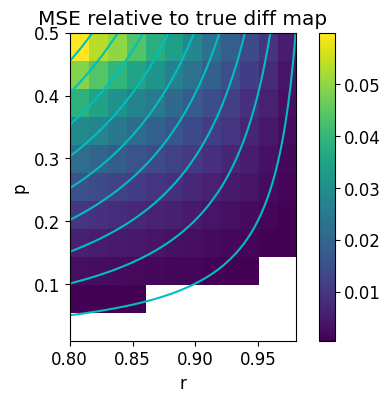

In [16]:
plt.figure(figsize=(6,4))
plt.imshow(MSE_obs[:,:,5],origin='lower',extent = (r_range[0],r_range[-1], p_range[0],p_range[-1]),aspect=0.5)
xlim=plt.xlim()
ylim=plt.ylim()
r_range=np.linspace(0.8,1,100)
c_range=np.linspace(0,1,100)
for c in c_range:
    plt.plot(r_range,c/(1-r_range),'c-')
plt.xlabel("r")
plt.ylabel("p")
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()
plt.title("MSE relative to true diff map")
plt.show()

The **cyan** curves above are curves of constant $p(1-r)$. On these curves, the map MSE is fairly close to constant. This suggests a helpful simplification: instead of the MSE being a function of three variables ($p, r, |E^{gs}|$), perhaps we can approximate it as a function of two variables ($p(1-r), |E^{gs}|$). We try this below:

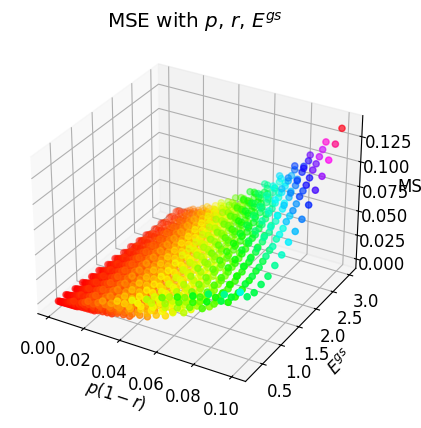

In [17]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection="3d")

bmask = MSE_obs_2d[:,2]<0.18
ax.scatter3D(MSE_obs_2d[bmask,0],MSE_obs_2d[bmask,1],MSE_obs_2d[bmask,2], c=MSE_obs_2d[bmask,2], cmap='hsv')
ax.set_xlabel(r"$p(1-r)$")
ax.set_ylabel(r"$E^{gs}$")
ax.set_zlabel("MSE")
ax.set_title(r"MSE with $p$, $r$, $E^{gs}$")
plt.show()

The nice thing about the above plot is that the MSE is in pretty good approximation a function of two rather than three parameters (collapsing $p$ and $r$ into $p(1-r)$). 

# The role of measurement error
A direct extension of the calculation of MSE map error above with additive noise terms for $|F^{on}|$ and $|F^{off}|$, shows that 

$$MSE_{meas.\  error} = MSE_{ideal} + k^2 \sigma^2_{on} + \sigma^2_{off}$$

We see this after 
1) setting, for simplicity, the phase of $F_{off}$ to zero, 
2) adding the noise terms to the calculation of $\Delta A$,
3) and assuming statistical independence between ground-state/excited-state differences and measurement errors. 

This provides a simple recipe for including measurement error in weight calculations:

$$w_{hkl}=\frac{1}{MSE_{ideal} + k^2 \sigma^2_{on} + \sigma^2_{off}}$$

In [18]:
def calc_MSE_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error, p, scale_by_p=True):
    '''
    As described above, this function calculates the expected mean square error (MSE) between a naive estimator 
    of the difference map (now in the presence of measurement errors) and the true difference map. 
    '''
    if scale_by_p:
        pscale = p
    else:
        pscale = 1
    
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    MSE = np.mean(np.abs(deltaF_off_phased - pscale*(E_es-E_gs))**2)
    return MSE

def calc_Cov_off_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error):
    '''
    This function calculated the covariance of a noisy difference map (in the presence of measurement errors
    with the true ground state.
    '''
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    Cov_off = np.mean(np.real(deltaF_off_phased) * np.real(E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_gs)**2)
    return [Cov_off, Cov_off/(np.sqrt(norm1*norm2))]

def calc_Corr_true_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error):
    '''
    This function calculates the expected covariance between a naive estimator 
    of the difference map (now in the presence of measurement errors) and the true difference map. 
    '''
    deltaF_off_phased = (k[0]*(E_on_abs+on_error) - k[1]*(E_off_abs+off_error))*np.exp(1j*phi_off)
    Cov_true = np.mean(np.real(deltaF_off_phased) * np.real(E_es-E_gs)+\
                      np.imag(deltaF_off_phased) * np.imag(E_es-E_gs)\
                     )
    norm1 = np.mean(np.abs(deltaF_off_phased)**2)
    norm2 = np.mean(np.abs(E_es-E_gs)**2)
    return Cov_true/(np.sqrt(norm1*norm2))

## 2D optimization

We repeat our 2D optimization for $k$ and $k'$ while accounting for measurement errors. 

In [19]:
rng  = default_rng()
r    = 0.95       # double-Wilson parameter
p    = 0.2        # excited state fraction
Nref = 100000

mean = [0,0,0,0]                
cov  = 0.5*np.asarray([[1, 0, r, 0 ],\
                       [0, 1, 0, r ],\
                       [r, 0, 1, 0 ],\
                       [0, r, 0, 1 ]])

vals = rng.multivariate_normal(mean, cov, Nref)

E_gs      = vals[:,0] + 1j * vals[:,1]
E_es      = vals[:,2] + 1j * vals[:,3]
E_off     = E_gs
E_on      = (1-p)*E_gs + p*E_es
phi_off   = np.angle(E_off)
phi_on    = np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

In [ ]:
sig_off = 0.05
sig_on  =  0.05
off_error = sig_off * np.random.normal(size=E_off_abs.shape) 
on_error  = sig_on  * np.random.normal(size=E_on_abs.shape )

nmax = 100
nmax2 = nmax # Used for validating image axes
MSE_obs     = np.zeros((nmax,nmax2))
corr_off_obs = np.zeros((nmax,nmax2))
corr_true   = np.zeros((nmax,nmax2))
mean_DoM    = np.zeros((nmax,nmax2))
k1_range = np.linspace(0.9,1.1,nmax)/p
k2_range = np.linspace(0.9,1.1,nmax2)/p
for k1 in tqdm(range(0,nmax)):
    for k2 in range(0,nmax2):
        k = [k1_range[k1],k2_range[k2]]
        MSE_obs[    k1,k2] = calc_MSE_w_meas_error(      k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error,p,\
                                                   scale_by_p=False)
        corr_off_obs[k1,k2] = calc_Cov_off_w_meas_error(  k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error)[1]
        corr_true[k1,k2]    = calc_Corr_true_w_meas_error(k, E_on_abs, phi_off, E_off_abs, E_es, E_gs, on_error, off_error)

 78%|███████▊  | 78/100 [02:01<00:33,  1.54s/it]

In [ ]:
plt.hist(E_off_abs+off_error,bins=50, density=True)

# k_emp = np.mean(E_off_abs + off_error)/np.mean(E_on_abs + on_error)
k_emp = np.median((E_off_abs + off_error)/(E_on_abs + on_error))
print(k_emp)

In [ ]:
%matplotlib inline
fig, _axs = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
extent = [k1_range[0], k1_range[-1], k2_range[0], k2_range[-1]]
axs = _axs.flatten()

axs[0].imshow(      MSE_obs, origin='lower', extent=extent)
cs = axs[0].contour(MSE_obs,\
                    levels=np.linspace(1.02*np.sqrt(min_MSE),\
                                       0.98*np.sqrt(max_MSE),12)**2,\
                    colors='w', extent=extent)

# cs = axs[0].contour(MSE_obs, levels=np.linspace(0,np.amax(MSE_obs.flatten()),21),colors='w', extent=extent)
axs[0].clabel(cs, inline=True, fontsize=10)
axs[0].plot(1/p,1/p,'w+',markersize=12)
axs[0].plot(k1_range[[0,-1]],k1_range[[0,-1]],'m--')
axs[0].plot(k1_range[[0,-1]], k_emp * k1_range[[0,-1]],'c--')
axs[0].set_title("MSE map error (over rnd SF pairs and map)")
axs[0].set_xlabel(r"$k_{on}$")
axs[0].set_ylabel(r"$k_{off}'$")
axs[0].set_xlim(k1_range[[0,-1]])
axs[0].set_ylim(k2_range[[0,-1]])

axs[1].imshow( np.abs(corr_off_obs), origin='lower', extent=extent)
cs=axs[1].contour(corr_off_obs,levels=np.linspace(-0.5,0.5,6),colors='w', extent=extent)
axs[1].clabel(cs, inline=True, fontsize=10)
axs[0].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[1].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[1].plot(1/p,1/p,'w+',markersize=12)
axs[1].plot(k1_range[[0,-1]],k1_range[[0,-1]],'m--')
axs[1].plot(k1_range[[0,-1]], k_emp * k1_range[[0,-1]],'c--')
axs[1].set_title("Corr with OFF map (over same)")
axs[1].set_xlabel(r"$k_{on}$")
axs[1].set_xlim(k1_range[[0,-1]])
axs[1].set_ylim(k2_range[[0,-1]])
# plt.scatter(cov_off_obs[np.abs(cov_off_obs<0.002)][:,0], cov_off_obs[np.abs(cov_off_obs<0.002)][:,1],'k.')
# plt.colorbar()

axs[2].imshow( corr_true, origin='lower', extent=extent)
cs=axs[2].contour(corr_true,levels=np.linspace(-1,1,81),colors='k', extent=extent)
axs[2].clabel(cs, inline=True, fontsize=10)
axs[2].contour(corr_off_obs,levels=[0],colors='r', extent=extent)
axs[2].plot(1/p,1/p,'k+',markersize=12)
axs[2].plot(k1_range[[0,-1]], k_emp * k1_range[[0,-1]],'c--')
axs[2].plot(k1_range[[0,-1]],k1_range[[0,-1]],'m--')
axs[2].set_title("Corr w\ true diff map (same)")
axs[2].set_xlabel(r"$k_{on}$")
# axs[2].set_xlim(k_range[[0,-1]])
# axs[2].set_ylim(k_range[[0,-1]])
plt.show()

By-and-large, the same conclusions hold as for the case without measurement error. $k=k'$ (magenta) performs pretty well, but applying a correction factor given by the median ratio of observed amplitudes (green dashed line) essentially removes all covariance with off (red line), while retaining most of the correlation with the true difference map.